# Project 5c-SIR models

A classic epidemiological model is called the SIR model, which stands for Susceptible-Infected-Recovered (or more broadly Removed, if the disease is potentially fatal).  As the name implies, this is a population model with three populations.  The equations are pretty simple (even simpler than zombies):
$$
\frac{\partial S}{\partial t} = -\beta S I
$$
$$
\frac{\partial I}{\partial t} = \beta S I - \gamma I
$$
$$
\frac{\partial R}{\partial t} = \gamma I,
$$
yet they have rather successfully been used to model a broad array of epidemics, including, in a practical sense, COVID-19.  Implement the above equations and explore their behavior for a few combinations of parameters and initial conditions.  What are the stable states?  Does this model exhibit periodicity?

In [1]:
import numpy as np
import ode_methods as om

class SIR:
    """ This is an example class for an ODE specification"""
    
    def __init__(self,beta=0.1,gamma=0.01):
        
        self.beta = beta
        self.gamma = gamma
        self.n_dof = 3
        
    def rhs(self,t,u):
        # 0 - S
        # 1 - I
        # 2 - R
        
        # the right hand side of the ode (or $\mathcal{F}(t,u)$)
        dudt = np.array([-self.beta*u[0]*u[1],
                         self.beta*u[0]*u[1] - self.gamma*u[1],
                         self.gamma*u[1]])  

        return dudt
method = om.Midpoint()

### Comparison to observations

While it is useful to examine the qualitative evolution of these systems, they are not necessarily useful for modelling real epidemics because it is not clear *a priori* what the values of the parameters ought to be.  In order to do that, they need to be tuned so as to reproduce a set of real observations.  I have provided for you code to read in and process data from the first year of the pandemic in Montana.

Text(0.5, 0, 'weeks')

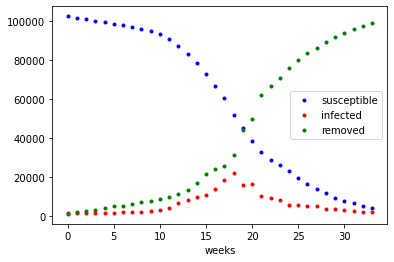

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('ef7e2f14.csv')

N = 1.05e5 # Initial susceptible population, here taken to be approximately 
          # 1/10 of the actual population of the state
          # or around the same amount of people that end up 
          # getting infected
removed = data['recovered'] + data['deaths']
infected = data['confirmed'] - removed
susceptible = N - infected - removed

removed = removed[removed.notnull()].to_numpy()[100::7]
infected = infected[infected.notnull()].to_numpy()[100::7]
susceptible = susceptible[susceptible.notnull()].to_numpy()[100::7]
times = np.linspace(0,len(susceptible)-1,len(susceptible))


plt.plot(times,susceptible,'b.',label='susceptible')
plt.plot(times,infected,'r.',label='infected')
plt.plot(times,removed,'g.',label='removed')
plt.legend()
plt.xlabel('weeks')

**"fit" the data, which is to say: come up with values for $\gamma$, $\beta$, and $I_0$ such that predictions from the model agree reasonably well with the observations.**

## Markov Chain Monte Carlo sampling (a more than brief aside)
Tuning models by hand is a tricky task, especially as the number of parameters gets large.  It's also quite subjective, and might not capture all of the possible configurations of the model that could fit the data equivalently well.  As such, we'd like to come up with an automated procedure for fitting models to data.  

This is of course, a rather vast subject.  Indeed, fitting (very flexible) models (with lots of parameters) to data is most of the content of a machine learning class.  In that context, the common practice is to define a cost function (commonly mean squared error) and minimize it using an algorithm called gradient descent.  Such an approach is possible here as well, but requires the efficient differentiation of the ordinary differential equation that we're solving itself using something called [the adjoint method](https://en.wikipedia.org/wiki/Adjoint_state_method).  This is a very interesting topic, but is a bit outside of the scope of our course.

Another downside to gradient descent is that it provides only a single set of optimal model parameters.  However, for real scientific applications, it's typically very useful for us to know something about the *distribution* of possible values that the parameters could take.  For that reason, we'll try to characterize our parameters as probability distributions.  To characterize them, we'll use a tool called the Metropolis-Hastings algorithm. 

### A small example from ballistics
Let's go back to a very simple ballistics problem, namely two dimensional motion without drag.  Recall that the equations were
$$
\frac{\partial \mathbf{x}}{\partial t} = \mathbf{v}
$$
$$
\frac{\partial \mathbf{v}}{\partial t} = \mathbf{g}
$$
where $\mathbf{x}$ is the position vector, $\mathbf{v}$ the velocity vector, $\mathbf{g}=[0,-9.81]^T$ the gravity vector.  The analytical solution to this is 
$$
\mathbf{x}(t) = \mathbf{x}_0 + \mathbf{v}_0 t + \frac{1}{2}\mathbf{g} t^2
$$
Let's say I *do* know the location from which the projectile was launched, but that I *don't* know its initial velocity.  This latter quantity I would like to infer.  I do have a noisy measurement of its position at some point in time.  As an example, lets say at $t = 1.0$s, I measure its position to be $\mathbf{x}(1s) = [10,3]$m.  What can I say about its initial position and velocity?  

Bayes' theorem gives us an answer:
$$
P(\mathbf{v}_0|\hat{\mathbf{x}}_1) = \frac{P(\hat{\mathbf{x}}_1|\mathbf{v}_0) P(\mathbf{v_0})}{P(\hat{\mathbf{x}}_1)},
$$
where I've used a hat to indicate an observed quantity.  

The term on the left hand side is what we want: the probability distribution of the initial position and velocity given the observed position at some time.  The right hand side includes things that we can make assumptions about.  $P(\mathbf{v}_0)$ is a *prior* distribution, which encodes the distribution of possible initial velocities before looking at any data.  Let's assume that this is proportional to 1, which is equivalent to saying that I don't know anything about the velocity to start with.  

The other term $P(\mathbf{x}_1|\mathbf{v}_0)$ is called a *likelihood*, and it asks the question "what is the probability of making the observation ($\hat{\mathbf{x}}_1$) for some given value of $\mathbf{v}_0$.  Answering this question has two parts here: first, I need to map from $\mathbf{v}_0$ to a hypothesized position at $t=1$s.  This is is easy to do with our model.  Define
$$
\mathbf{x}_1(\mathbf{v}_0) \equiv \mathbf{x}_0 + \mathbf{v}_0 (1) + \frac{1}{2} \mathbf{g} (1)^2.
$$
Second, we need to make an assumption about uncertainty in our measurement.  A common and sometimes justified approach is to say that the observation is *normally* distributed around the true value, i.e.
$$
\hat{\mathbf{x}}_1 = \mathbf{x}_1 + \boldsymbol{\epsilon }
$$
$$
\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0},\Sigma)
$$
$$
\Sigma = \begin{bmatrix} \sigma^2_{obs} & 0 \\ 0 & \sigma^2_{obs} \end{bmatrix}
$$
More concisely, we can write
$$
P(\hat{\mathbf{x}}_1 | \mathbf{v}_0) = \mathcal{N}(\mathbf{x}_1(\mathbf{v}_0), \Sigma).
$$

Finally, we have the denominator term
$$
P(\hat{\mathbf{x}}_1) = \int P(\hat{\mathbf{x}_1}|\mathbf{v}_0) P (\mathbf{v}_0) \; \mathrm{d}\mathbf{v}_0,
$$
which is sometimes called the *evidence*.  This is quite pesky to evaluate because that integral is over all possible values of $\mathbf{v}_0$.  In fact, for most non-trivial models, it's impossible to compute exactly, and it is from this intractibility that most of the richness of Bayesian statistics emerges.

One idea (which is popular in machine learning) is to simply *maximize* $P(\mathbf{v}_0 | \hat{\mathbf{x}}_1)$.  Because $\hat{\mathbf{x}}_1$ does not depend upon the velocity, it's a constant and we can ignore it.  However, this does not yield any notion of uncertainty.  Another relatively simple idea is to perform a brute force Monte Carlo integration: randomly sample a large number of $\mathbf{v}_0$, and compute the integral as 
$$
\int P(\hat{\mathbf{x}_1}|\mathbf{v}_0) P (\mathbf{v}_0) \; \mathrm{d}\mathbf{v}_0 \approx \frac{1}{N} \sum_{j=1}^N P(\hat{\mathbf{x}_1}|\mathbf{v}_{0,j}) 
$$
with 
$\mathbf{v}_{0,j}$ a sample drawn from a prior distribution over $\mathbf{v}$.  Of course, we said that this was just going to be proportional to 1, which means that any pair of real numbers is equally likely, and this just won't work.  Instead, let's put a simple bound and say that our initial velocities are between 0 and 20.  

It is easiest to see how this works in code.  First, let's make a function that evaluates the posterior up to a multiplicative constant (or rather its logarithm).

In [3]:
class ProjectilePosterior:
    def __init__(self,x_0,g,x_obs,t_obs,sigma2_obs):
        self.x_0 = x_0
        self.g = g
        self.x_obs = x_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,v_0):
        x_pred = self.x_0 + v_0*self.t_obs[:,np.newaxis] + 0.5*self.g*self.t_obs[:,np.newaxis]**2
        P = -(0.5*(x_pred - x_obs)**2/sigma2_obs 
             + 0.5*np.log(sigma2_obs) 
             + 0.5*(np.log(2*np.pi))).sum()
        return P

In [4]:
x_obs = np.array([10,3])
t_obs = np.array([1.])
sigma2_obs = 0.1
x_0 = np.array([0.,0.])
g = np.array([0,-9.81])

proj_like = ProjectilePosterior(x_0,g,x_obs,t_obs,sigma2_obs)

v_0 = np.array([1.,1.])
print(proj_like.log_posterior(v_0))


-642.9304169734153


Let's draw some samples of possible values of $v_0$ and evaluate them.

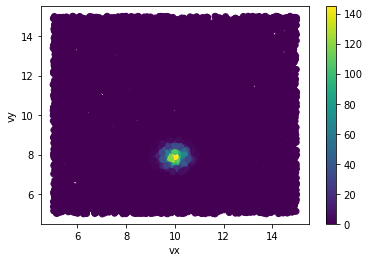

In [5]:
v_samples = np.random.rand(10000,2)*10 + 5
log_posteriors = np.array([proj_like.log_posterior(v) for v in v_samples])
posteriors = np.exp(log_posteriors)
mean_posteriors = posteriors.mean()
posteriors/=mean_posteriors

plt.scatter(*v_samples.T,c=posteriors)
plt.xlabel('vx')
plt.ylabel('vy')
plt.colorbar()

We can plot trajectories for each of these samples, with the alpha channel set to be proportional to the probabilities

Text(0, 0.5, 'y')

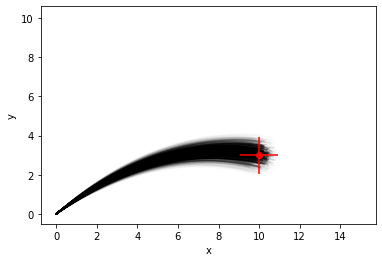

In [6]:
t = np.linspace(0,1,101)
for i in range(10000):
    sol = x_0 + np.outer(t,v_samples[i]) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=posteriors[i]/posteriors.max())
plt.errorbar([x_obs[0]],[x_obs[1]],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

This works really well!  Except that we start to run into a problem as the dimensionality of the system increases.  With 10000 points in 2D space, we have around 100 samples per side.  If we were working in 3D space (let's say that we also didn't know one component of the initial position) and had the same number of total random points: now we'd only have $N=10000^{\frac{2}{3}}$ points for some cross section.  This sampling density would look like this:

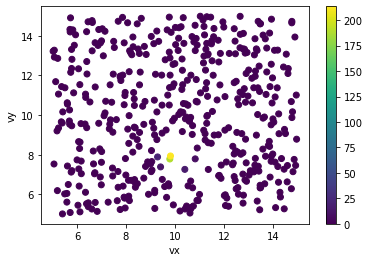

In [7]:
v_samples = np.random.rand(int(10000**(2./3.)),2)*10 + 5
log_posteriors = np.array([proj_like.log_posterior(v) for v in v_samples])
posteriors = np.exp(log_posteriors)
mean_posteriors = posteriors.mean()
posteriors/=mean_posteriors

plt.scatter(*v_samples.T,c=posteriors)
plt.xlabel('vx')
plt.ylabel('vy')
plt.colorbar()

This becomes problematic quickly.  An alternative method that doesn't have all the same shortcomings is to use the Metropolis algorithm, which is a type of Markov Chain Monte Carlo (MCMC) method (Monte Carlo because it's random, Markov Chain because we create new samples by making a small perturbation to an existing sample).  The algorithm is quite simple.  We begin with some random value for $\mathbf{v}_0$.  Next, we make a small modification according to a so-called proposal distribution $$
q(\mathbf{v}_{0,i+1} | \mathbf{v}_{0,i}) = \mathcal{N}(\mathbf{v}_{0,i} | h^2),
$$
where $h$ is a (usually pretty small) step size.  We then evaluate the posterior for the new location and for the current location.  If
$$
\frac{P(\mathbf{v}_{0,i+1})}{P(\mathbf{v}_{0,i})} \ge 1,
$$
then we accept the proposed value of $\mathbf{v}_0$.  If 
$$
\frac{P(\mathbf{v}_{0,i+1})}{P(\mathbf{v}_{0,i})} < 1,
$$
then we accept with probability given by this ratio.  We then repeat this process many times, saving the result of the sampling at each step in the algorithm.  It turns out that the values stored in the chain are samples from the posterior distribution.  Let's see how this works.  

In [8]:
v_0 = np.array([1.,1.])
P_0 = proj_like.log_posterior(v_0)

P_chain = [P_0]
v_chain = [v_0]
h = 0.1
for i in range(10000):

    v_prime = v_0 + np.random.randn(2)*h

    P_1 = proj_like.log_posterior(v_prime)
    log_ratio = P_1 - P_0
    ratio = np.exp(log_ratio)
    if ratio>np.random.rand():
        v_0 = v_prime
        P_0 = P_1
        
    P_chain.append(P_0)
    v_chain.append(v_0)
    
burnin = 0
P_chain = np.array(P_chain[burnin:])
v_chain = np.array(v_chain[burnin:])

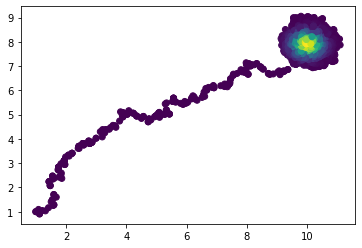

In [9]:
plt.scatter(*v_chain.T,c=np.exp(P_chain))

Text(0, 0.5, 'y')

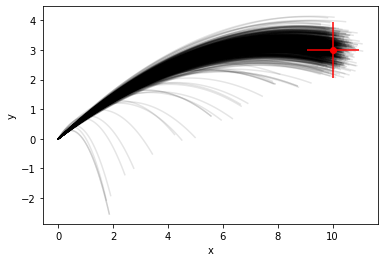

In [10]:
t = np.linspace(0,1,101)
for i in range(1000):
    i = np.random.randint(v_chain.shape[0])
    sol = x_0 + np.outer(t,v_chain[i]) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=0.1)
plt.errorbar([x_obs[0]],[x_obs[1]],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

Of course we could do the same thing but with more unknowns.  For example, we could assume that *both* initial velocity and initial position are unknown.  However, before we start, we should ask whether this problem is well posed.  

In [11]:
class ProjectilePosteriorWithX:
    def __init__(self,g,x_obs,t_obs,sigma2_obs):
        self.g = g
        self.x_obs = x_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,x_0,v_0):
        x_pred = x_0 + v_0*self.t_obs[:,np.newaxis] + 0.5*self.g*self.t_obs[:,np.newaxis]**2
        P = -(0.5*(x_pred - x_obs)**2/sigma2_obs 
             + 0.5*np.log(sigma2_obs) 
             + 0.5*(np.log(2*np.pi))).sum()
        return P

In [12]:
proj_like = ProjectilePosteriorWithX(g,x_obs,t_obs,sigma2_obs)

v_0 = np.array([1.,1.])
x_0 = np.array([0,0])
P_0 = proj_like.log_posterior(x_0,v_0)

P_chain = [P_0]
x_chain = [x_0]
v_chain = [v_0]
h = 0.1
for i in range(100000):

    x_prime = x_0 + np.random.randn(2)*h
    v_prime = v_0 + np.random.randn(2)*h

    P_1 = proj_like.log_posterior(x_prime,v_prime)
    log_ratio = P_1 - P_0
    ratio = np.exp(log_ratio)
    if ratio>np.random.rand():
        x_0 = x_prime
        v_0 = v_prime
        P_0 = P_1
        
    P_chain.append(P_0)
    v_chain.append(v_0)
    x_chain.append(x_0)
    
burnin = 1000
P_chain = np.array(P_chain[burnin:])
v_chain = np.array(v_chain[burnin:])
x_chain = np.array(x_chain[burnin:])

Text(0, 0.5, 'y')

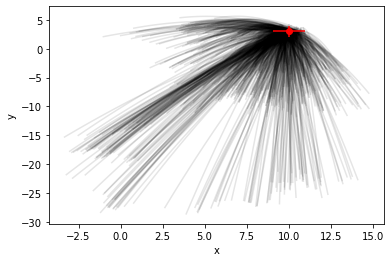

In [13]:
t = np.linspace(0,1,101)
for i in range(1000):
    i = np.random.randint(v_chain.shape[0])
    sol = x_chain[i] + np.outer(t,v_chain[i]) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=0.1)
plt.errorbar([x_obs[0]],[x_obs[1]],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

Lots of possible solutions are consistent with this data!  What if we change up the situation and say that we add a second observation, namely that $\hat{\mathbf{x}}_{t=1/2} = \begin{bmatrix} 5 \\ 2 \end{bmatrix} $

In [14]:
x_obs = np.array([[5,2],[10,3]])
t_obs = np.array([0.5,1.])
sigma2_obs = 0.1

proj_like = ProjectilePosteriorWithX(g,x_obs,t_obs,sigma2_obs)

v_0 = np.array([1.,1.])
x_0 = np.array([0,0])
P_0 = proj_like.log_posterior(x_0,v_0)

P_chain = [P_0]
x_chain = [x_0]
v_chain = [v_0]
h = 0.1
for i in range(100000):

    x_prime = x_0 + np.random.randn(2)*h
    v_prime = v_0 + np.random.randn(2)*h

    P_1 = proj_like.log_posterior(x_prime,v_prime)
    log_ratio = P_1 - P_0
    ratio = np.exp(log_ratio)
    if ratio>np.random.rand():
        x_0 = x_prime
        v_0 = v_prime
        P_0 = P_1
        
    P_chain.append(P_0)
    v_chain.append(v_0)
    x_chain.append(x_0)
    
burnin = 1000
P_chain = np.array(P_chain[burnin:])
v_chain = np.array(v_chain[burnin:])
x_chain = np.array(x_chain[burnin:])

Text(0, 0.5, 'y')

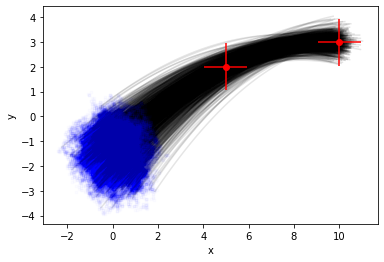

In [15]:
t = np.linspace(0,1,101)
for i in range(1000):
    i = np.random.randint(v_chain.shape[0])
    sol = x_chain[i] + np.outer(t,v_chain[i]) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=0.1)
plt.errorbar(x_obs[:,0],x_obs[:,1],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.plot(x_chain[:,0],x_chain[:,1],'b.',alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')

### MCMC for SIR modelling
We can proceed with using the Metropolis algorithm to find the initial conditions *and* parameters of an SIR model in much the same way as above.  The only difference is in the number of parameters (here we'll have 5) and how we compute the proportional log-posterior (it will involve the solution of our ODE!).  



In [16]:
class SIRPosterior:
    def __init__(self,t_obs,u_obs,sigma2_obs):
        self.u_obs = u_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,log_m):
        m = np.exp(log_m)
        S_0 = m[0]
        I_0 = m[1]
        R_0 = m[2]
        beta = m[3]
        gamma = m[4]
        
        u0 = np.array([S_0,I_0,R_0])

        s = SIR(beta=beta,gamma=gamma)
        integrator = om.Integrator(s,method)
        t,u = integrator.integrate([times[0],times[-1]],1,u0)
        P = -0.5*np.sum((self.u_obs - u)**2)/self.sigma2_obs
        return P


In [17]:
S_obs = susceptible/N
I_obs = infected/N
R_obs = removed/N

u_obs = np.c_[S_obs,I_obs,R_obs]

sigma2_obs = 0.01

sir_like = SIRPosterior(t_obs,u_obs,sigma2_obs)

m_0 = np.log(np.array([1.0,0.01,0.1,3.0,1.0]))
P_0 = sir_like.log_posterior(m_0)

P_chain = [P_0]
m_chain = [m_0]
h = 0.1
for i in range(100000):

    m_prime = m_0 + np.random.randn(5)*h

    P_1 = sir_like.log_posterior(m_prime)
    log_ratio = P_1 - P_0
    ratio = np.exp(log_ratio)
    if ratio>np.random.rand():
        m_0 = m_prime
        P_0 = P_1
        
    P_chain.append(P_0)
    m_chain.append(m_0)
    
burnin = 1000
P_chain = np.array(P_chain[burnin:])
m_chain = np.array(m_chain[burnin:])

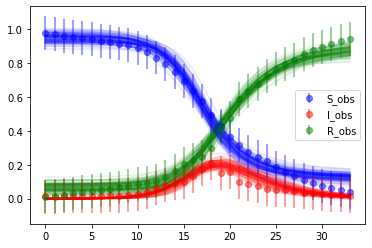

In [18]:
for i in range(100):
    j = np.random.randint(len(m_chain))
    m_best = np.exp(m_chain[j])
    S_0 = m_best[0]
    I_0 = m_best[1]
    R_0 = m_best[2]
    beta = m_best[3]
    gamma = m_best[4]

    u0 = np.array([S_0,I_0,R_0])
    s = SIR(beta=beta,gamma=gamma)
    integrator = om.Integrator(s,method)
    t,u = integrator.integrate([times[0],times[-1]],1,u0)

    plt.plot(t,u[:,0],'b-',alpha=0.1)
    plt.plot(t,u[:,1],'r-',alpha=0.1)
    plt.plot(t,u[:,2],'g-',alpha=0.1)
plt.errorbar(times,S_obs,yerr=np.sqrt(sigma2_obs),fmt='bo',label='S_obs',alpha=0.5)
plt.errorbar(times,I_obs,yerr=np.sqrt(sigma2_obs),fmt='ro',label='I_obs',alpha=0.5)
plt.errorbar(times,R_obs,yerr=np.sqrt(sigma2_obs),fmt='go',label='R_obs',alpha=0.5)
plt.legend()

Pretty good fit (although there are details that the model is missing).  One critical piece of information that epidemiologists care about is the basic reproduction number, called $R_0$ which is, roughly speaking, the number of other people that a single infected person is likely to infect.  This number has a direct link to SIR models, because it can be computed as the ratio of $\beta$ and $\gamma$.  We can do one better than estimation: we can estimate the distribution of $R_0$ that is consistent with observations.  Let's produce a simple histogram:

(array([0.04439382, 0.43788092, 1.89124067, 2.62170638, 1.82883427,
        0.76704877, 0.21519448, 0.06455834, 0.01681705, 0.00286926]),
 array([2.04383711, 2.17057109, 2.29730506, 2.42403904, 2.55077301,
        2.67750699, 2.80424096, 2.93097494, 3.05770891, 3.18444289,
        3.31117686]),
 <BarContainer object of 10 artists>)

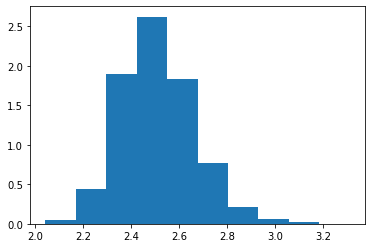

In [19]:
plt.hist(np.exp(m_chain)[:,3]/np.exp(m_chain)[:,4],density=True)

It would appear that our estimated $R_0$ is between 2 and 2.7.  This is in strong agreement with the independently estimated COVID-19 values!